In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘tibble’ was built under R version 3.6.3”
Warning message:
“package ‘tidyr’ was built under R version 3.6.3”
Warning message:
“package ‘purrr’ was built under R version 3.6.3”
Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Warning message:
“package ‘stringr’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘repr’ was built under R version 3.6.3”
Warning message:
“package ‘infer’ was built u

Select neccesary data

In [2]:
history_data <- read_csv("data/history.csv")
statement_data <- read_csv("data/statement.csv") %>%
    filter(`Account Type` == "Chequing") %>%
    rbind(history_data)%>%
    select("Transaction Date", "Description 2", "CAD$")%>%
    rename("Transaction"="CAD$")
head(statement_data, n=10)

Parsed with column specification:
cols(
  `Account Type` = col_character(),
  `Account Number` = col_character(),
  `Transaction Date` = col_character(),
  `Cheque Number` = col_logical(),
  `Description 1` = col_character(),
  `Description 2` = col_character(),
  `CAD$` = col_double(),
  `USD$` = col_logical()
)

Warning message:
“313 parsing failures.
row col  expected    actual               file
  1  -- 8 columns 9 columns 'data/history.csv'
  2  -- 8 columns 9 columns 'data/history.csv'
  3  -- 8 columns 9 columns 'data/history.csv'
  4  -- 8 columns 9 columns 'data/history.csv'
  5  -- 8 columns 9 columns 'data/history.csv'
... ... ......... ......... ..................
See problems(...) for more details.
”
Parsed with column specification:
cols(
  `Account Type` = col_character(),
  `Account Number` = col_character(),
  `Transaction Date` = col_character(),
  `Cheque Number` = col_logical(),
  `Description 1` = col_character(),
  `Description 2` = col_character(),
  `CAD$` = col

Transaction Date,Description 2,Transaction
<chr>,<chr>,<dbl>
7/9/2021,BREKA BAKERY,-15.70
7/9/2021,SAVE ON FOODS #,-19.79
7/9/2021,DOORDASH*SUBWAY,-17.50
7/9/2021,PAYPAL *DISNEYP,-39.19
7/12/2021,PTB DEP -- VL273670,125.00
7/12/2021,SAVE ON FOODS #,62.99
7/12/2021,BOOKSTORE STARB,-15.38
7/12/2021,SAVE ON FOODS #,-90.96
7/12/2021,DOORDASH*CHICKE,-22.98


Categorize transactions

In [3]:
lookup_data <- read_csv("data/lookup_table.csv")
head(lookup_data)

Parsed with column specification:
cols(
  `Description 2` = col_character(),
  type = col_character()
)

Warning message:
“2 parsing failures.
row           col           expected actual                    file
111 Description 2 delimiter or quote      R 'data/lookup_table.csv'
111 Description 2 delimiter or quote      S 'data/lookup_table.csv'
”


Description 2,type
<chr>,<chr>
WENDY'S RESTAUR,Restaurant
SHOPPERS DRUG M,Groceries
SAVE ON FOODS #,Groceries
"#327 SPORT CHEK""",Personal
7-ELEVEN STORE,Groceries
A W STORE# 0751,Restaurant


Merge transaction type with remaining data and remove vendor name

In [4]:
merged_data <- merge(statement_data, lookup_data)%>%
    select(-"Description 2")
head(merged_data, n=10)

,Transaction Date,Transaction,type
,<chr>,<dbl>,<chr>
1,6/3/2021,-3.05,Groceries
2,4/12/2021,-13.31,Restaurant
3,5/25/2021,-20.48,Personal
4,6/14/2021,-145.54,Personal
5,5/17/2021,-20.48,Personal
6,6/21/2021,-23.91,Personal
7,4/30/2021,-32.12,Personal
8,5/28/2021,-20.48,Personal
9,5/20/2021,20.48,Personal


Minor clean up

In [9]:
savings_filter <- filter(merged_data, type=="Savings")%>%
    mutate(Transaction = abs(Transaction))
cleaned_data <- filter(merged_data, type!="Savings")%>%
    rbind(savings_filter)
head(cleaned_data, n=10)

,Transaction Date,Transaction,type
,<chr>,<dbl>,<chr>
1,6/3/2021,-3.05,Groceries
2,4/12/2021,-13.31,Restaurant
3,5/25/2021,-20.48,Personal
4,6/14/2021,-145.54,Personal
5,5/17/2021,-20.48,Personal
6,6/21/2021,-23.91,Personal
7,4/30/2021,-32.12,Personal
8,5/28/2021,-20.48,Personal
9,5/20/2021,20.48,Personal


Separate Transaction date into multiple columns

In [6]:
date_no_delimiter <- separate(cleaned_data,
                             col = "Transaction Date",
                             into = c("Month", "Day", "Year"),
                             sep = "/")
date_sorted <- arrange(date_no_delimiter, Year, Month, Day)
head(date_sorted)

,Month,Day,Year,Transaction,type
,<chr>,<chr>,<chr>,<dbl>,<chr>
1,3,10,2021,-10.38,Restaurant
2,3,11,2021,-10.49,Restaurant
3,3,11,2021,-6.71,Groceries
4,3,15,2021,-13.42,Personal
5,3,15,2021,-21.97,Personal
6,3,15,2021,-23.08,Personal


Group by month

In [7]:
monthly_summary <- aggregate(date_no_delimiter$Transaction, by=list(Type=date_no_delimiter$type,
                                                                Month=date_no_delimiter$Month,
                                                                Year=date_no_delimiter$Year),
                            FUN=sum)
monthly_summary

Type,Month,Year,x
<chr>,<chr>,<chr>,<dbl>
Allowance,3,2021,50.00
Groceries,3,2021,-3.72
Personal,3,2021,-1233.79
Restaurant,3,2021,-160.43
Allowance,4,2021,5000.00
Groceries,4,2021,-432.94
Personal,4,2021,-1109.23
Restaurant,4,2021,-535.37
Subscriptions,4,2021,-15.49


Visualizations

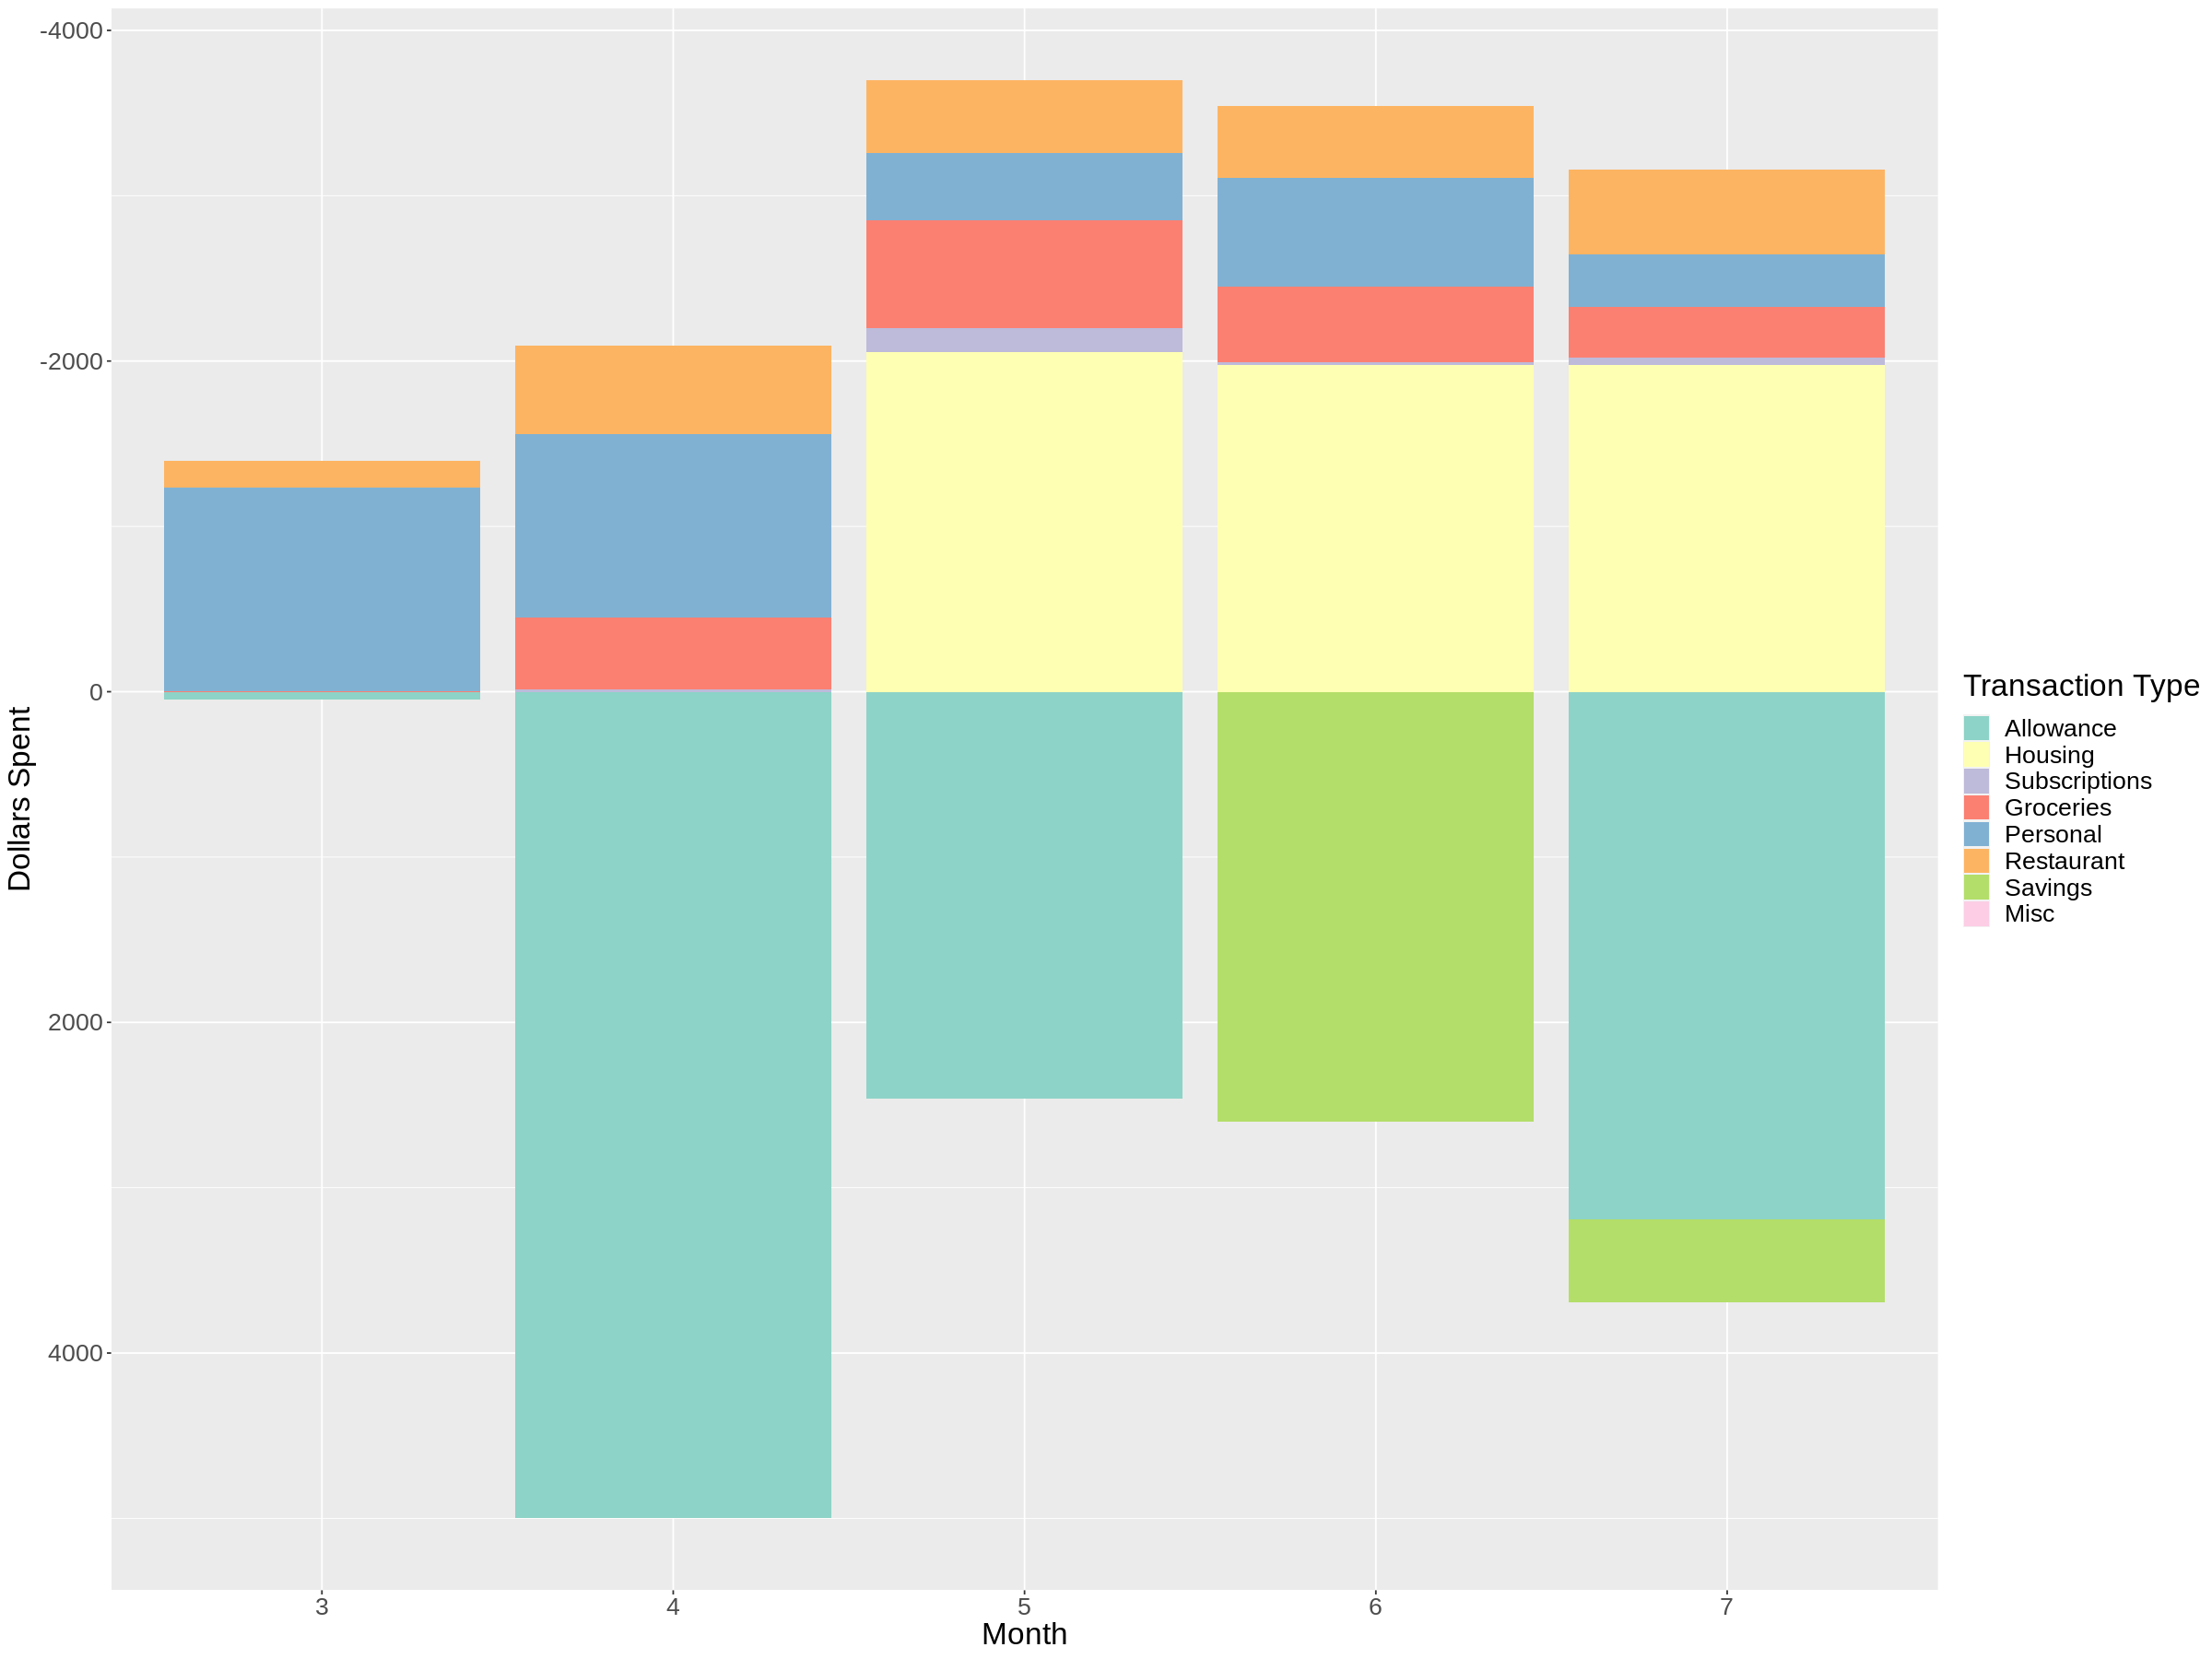

In [8]:
options(repr.plot.width = 20, repr.plot.height = 15)
usage_chart <- ggplot(monthly_summary, aes(x=Month, y=x, fill=factor(Type, levels=
                                                                          c("Allowance", 
                                                                            "Housing", 
                                                                            "Subscriptions", 
                                                                            "Groceries", 
                                                                            "Personal", 
                                                                            "Restaurant", 
                                                                            "Savings", 
                                                                            "Misc")))) +
    geom_bar(stat = "identity", position = position_stack(reverse = TRUE)) + 
    labs(x="Month", y="Dollars Spent", fill="Transaction Type")+
    scale_y_reverse()+ 
    scale_fill_brewer(palette='Set3')+
    theme(text = element_text(size = 20))
usage_chart